# Project: “Mapping Extreme Heat Trends in California”
## Tasks: data ingestion, annual counts, visual storytelling, CSV

### Outline
1. Download daily maximum temperature CSV files per county seat for historical (1950-2005) and RCP4.5 forecast (2006-2100) from CalAdapt data download API (LOCA Downscaled CMIP5 Climate Projections from Scripps Institution of Oceanography). CanESM2 was selected as global climate model (GCM) that is thought to produce "an average simulation" out of the 4 priority models (https://cal-adapt.org/help/faqs/what-climate-models-should-i-use-in-my-analysis-what-are-the-priority-models/)
2. Number of days per year exceeding 35 degrees Celcius ("above threshold days") calculated per country across all time periods (1950-2100)
3. Regression to understand how number of above threshold days are changing by county in RCP4.5 scenario vs. historical
4. Clustered counties by rate of change and average above threshold days and compared counties with existing climate action (or similar) plans

In [4]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
import matplotlib as mpl

### Data cleaning and above-threshold days analysis
Download data using 02_File_download.ipynb
Paths to raw per-county, combined by scenario, and county list CSV files

In [5]:
raw_path = r'C:\Users\skino\anaconda3\envs\07_CalAdapt_Heat\00 notebooks\caladapt_can3sm2_countyseat'
combined_path = r'C:\Users\skino\anaconda3\envs\07_CalAdapt_Heat\00 notebooks\caladapt_can3sm2_countyseat_combined'
target_counties = pd.read_csv('CACounties.csv')['County'].tolist()

In [6]:
for county in target_counties:
    dfs = []
    for fp in glob.glob(os.path.join(raw_path, f"*_{county}.csv")):
        df = pd.read_csv(fp)
        scenario = os.path.basename(fp).rsplit(f"_{county}.csv", 1)[0]
        if 'tasmax' not in df.columns:
            cols = df.columns.tolist()
            if len(cols) >= 2:
                df.rename(columns={cols[1]: 'tasmax'}, inplace=True)
        df['scenario'] = scenario
        dfs.append(df[['time','tasmax','scenario']])
    if dfs:
        long_df = pd.concat(dfs, ignore_index=True)
        long_df.to_csv(os.path.join(combined_path, f"tasmax_day_CanESM2_comb_{county}.csv"), index=False)

### Calculating extreme heat days using a selected temperature threshold

In [7]:
given_threshold_C = 35.0
all_counts = []
for fp in glob.glob(os.path.join(combined_path, '*.csv')):
    df = pd.read_csv(fp)
    df['time'] = pd.to_datetime(df['time'])
    df['year'] = df['time'].dt.year
    df['tasmax_C'] = df['tasmax'] - 273.15
    df['above_threshold'] = df['tasmax_C'] > given_threshold_C
    yearly = df.groupby(['year', 'scenario']).above_threshold.sum().reset_index()
    yearly.rename(columns={'above_threshold': f'Days > {given_threshold_C}°C'}, inplace=True)
    yearly['source_file'] = os.path.basename(fp)
    all_counts.append(yearly)

In [8]:
combined = pd.concat(all_counts, ignore_index=True)

In [9]:
files = combined['source_file'].unique()
cmap = mpl.colormaps['tab20'].resampled(len(files))
color_map = {f: cmap(i) for i, f in enumerate(files)}

### Polynomial regression of annual extreme heat days by scenario and county
Effectively limited to linear regression (degree_range) as introducing more variability does not yield significant improvement in fit and interpretability


In [11]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [12]:
degree_range = range(1, 2)
best_degrees = []
for (src, scen), grp in combined.groupby(['source_file','scenario']):
    grp = grp.sort_values('year')
    X = grp['year'].values.reshape(-1, 1)
    y = grp[f'Days > {given_threshold_C}°C'].values
    if len(X) < 5:
        continue
    degree_scores = {}
    for deg in degree_range:
        poly = PolynomialFeatures(degree=deg, include_bias=True)
        X_poly = poly.fit_transform(X)
        model = LinearRegression()
        scores = cross_val_score(model, X_poly, y, cv=5, scoring='r2')
        degree_scores[deg] = scores.mean()
    best_deg = max(degree_scores, key=degree_scores.get)
    best_degrees.append({
        'source_file': src,
        'scenario': scen,
        'best_degree': best_deg,
        'mean_cv_R2': degree_scores[best_deg]
    })
# Summary DataFrame
opt_df = pd.DataFrame(best_degrees)

C:\Users\skino\AppData\Local\Temp\ipykernel_27552\466150257.py:35: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


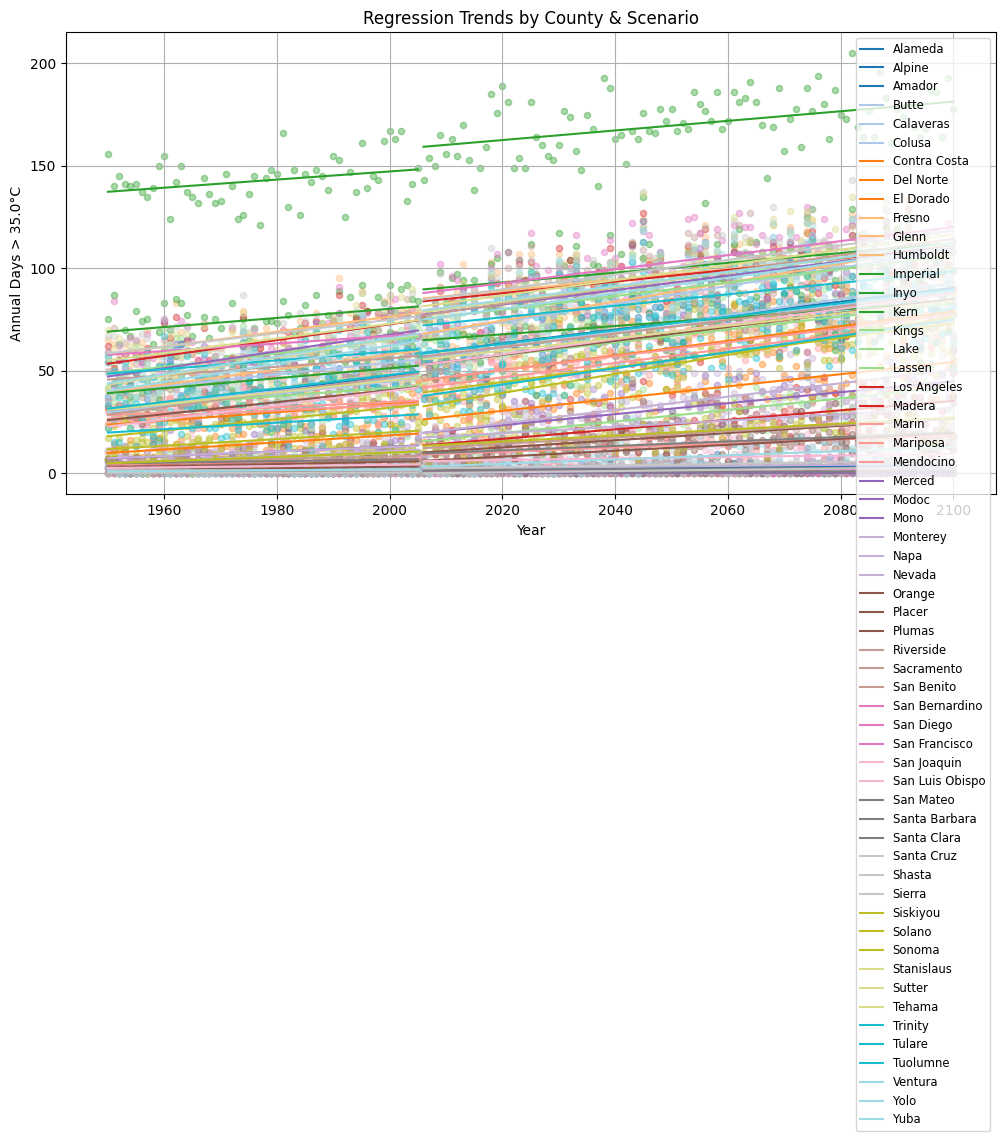

In [17]:
plt.figure(figsize=(12, 6))
labeled = set()
for _, row in opt_df.iterrows():
    src  = row['source_file']
    scen = row['scenario']
    deg  = row['best_degree']
    county = os.path.splitext(src)[0].split('_comb_')[-1]

    grp = (combined
           [(combined['source_file']==src)&(combined['scenario']==scen)]
           .sort_values('year'))
    X = grp['year'].values.reshape(-1,1)
    y = grp[f'Days > {given_threshold_C}°C'].values

    poly   = PolynomialFeatures(degree=deg, include_bias=True)
    X_poly = poly.fit_transform(X)
    model  = LinearRegression().fit(X_poly, y)

    X_smooth = np.linspace(X.min(), X.max(), 200).reshape(-1,1)
    y_smooth = model.predict(poly.transform(X_smooth))

    if county not in labeled:
        line_label = county
        labeled.add(county)
    else:
        line_label = None

    plt.scatter(X, y, alpha=0.4, color=color_map[src], s=20)
    plt.plot(X_smooth, y_smooth, label=line_label, color=color_map[src])
plt.xlabel('Year')
plt.ylabel(f'Annual Days > {given_threshold_C}°C')
plt.title('Regression Trends by County & Scenario')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

Export summary CSV with key metrics

In [18]:
summary_list = []
for _, row in opt_df.iterrows():
    src = row['source_file']
    scen = row['scenario']
    grp = combined[(combined['source_file'] == src) & (combined['scenario'] == scen)].sort_values('year')
    X = grp['year'].values.reshape(-1, 1)
    y = grp[f'Days > {given_threshold_C}°C'].values
    lr = LinearRegression().fit(X, y)
    slope = lr.coef_[0]
    avg_days = y.mean()
    cv_r2 = row['mean_cv_R2']
    fname = os.path.splitext(src)[0]
    if '_comb_' in fname:
        county = fname.split('_comb_')[-1]
    else:
        county = fname
    summary_list.append({
        'county': county,
        'scenario': scen,
        'slope_days_per_year': slope,
        'avg_annual_days_above_threshold': avg_days,
        'mean_cv_R2': cv_r2
    })
summary_df = pd.DataFrame(summary_list)

In [19]:
wide_df = summary_df.pivot(index='county', columns='scenario')
wide_df.columns = [f"{metric}_{scenario}" for metric, scenario in wide_df.columns]
wide_df.reset_index(inplace=True)

### Cluster counties by average days above threshold and slope of warming
Goal to find commonalities between counties based on historical and future rates of change and historical and future absolute days above threshold. Planning and policy decisions may differ by these combinations
such as a historically "cooler" county warming faster will need a different response to a historically "hotter" county warming slower. K-Means clustering applied on slopes and average days above threshold in each scenario, as one clustering appoach. 
Other approaches to clustering could include:
1. Plotting difference in slope between historical & future vs. difference in average days above threshold
(investigate how different the future looks for each county both in change and absolute)
2. plotting historical vs. future slope
(focus more on rate of change)

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [21]:
feature_cols = wide_df.columns.tolist()[1:5]
X_cluster = wide_df[feature_cols].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

In [22]:
# Fit KMeans for 3 clusters determined using the elbow method
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)
wide_df['cluster'] = labels

c:\Users\skino\anaconda3\envs\07_CalAdapt_Heat\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [23]:
out_fname = '01 regression_kmcluster_county_summary.csv'
wide_df.to_csv(out_fname, index=False)
print(f"Saved wide-format summary CSV to '{out_fname}'.")

Saved wide-format summary CSV to '01 regression_kmcluster_county_summary.csv'.


Summarize average slope and average days above threshold per cluster (Centroid)

In [24]:
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroid_df = pd.DataFrame(centroids, columns=feature_cols)
centroid_df.index.name = 'cluster'
out_fname = '02 kmcluster_centroid.csv'
centroid_df.to_csv(out_fname, index=False)
print("Cluster centroids (KMeans centers in original units):")
print(centroid_df)

Cluster centroids (KMeans centers in original units):
         slope_days_per_year_tasmax_day_CanESM2_historical  \
cluster                                                      
0                                                 0.161956   
1                                                 0.025561   
2                                                 0.318904   

         slope_days_per_year_tasmax_day_CanESM2_rcp45  \
cluster                                                 
0                                            0.341629   
1                                            0.070532   
2                                            0.335423   

         avg_annual_days_above_threshold_tasmax_day_CanESM2_historical  \
cluster                                                                  
0                                                21.267857               
1                                                 2.573052               
2                                                54.9

### Visualize clusters on California county map

In [27]:
import geopandas as gpd
import requests
from shapely.geometry import shape
import pandas as pd

In [28]:
api = 'http://api.cal-adapt.org/api'
resource = 'counties'
headers = {'Content-Type': 'application/json'}

In [30]:
geojson_url = f"{api}/{resource}/?format=geojson&pagesize=100"
counties_gdf = gpd.read_file(geojson_url)
if 'state_name' in counties_gdf.columns:
    counties_gdf = counties_gdf[counties_gdf['state_name'] == 'California']
    print(f"Filtered to {len(counties_gdf)} California counties")
plan_df = pd.read_csv('CACounties.csv')[['County', 'Plan_seat']]
merged = (
    counties_gdf
    .merge(wide_df[['county','cluster']], left_on='name', right_on='county', how='left')
    .merge(plan_df, left_on='name', right_on='County', how='left')
)

Filtered to 58 California counties


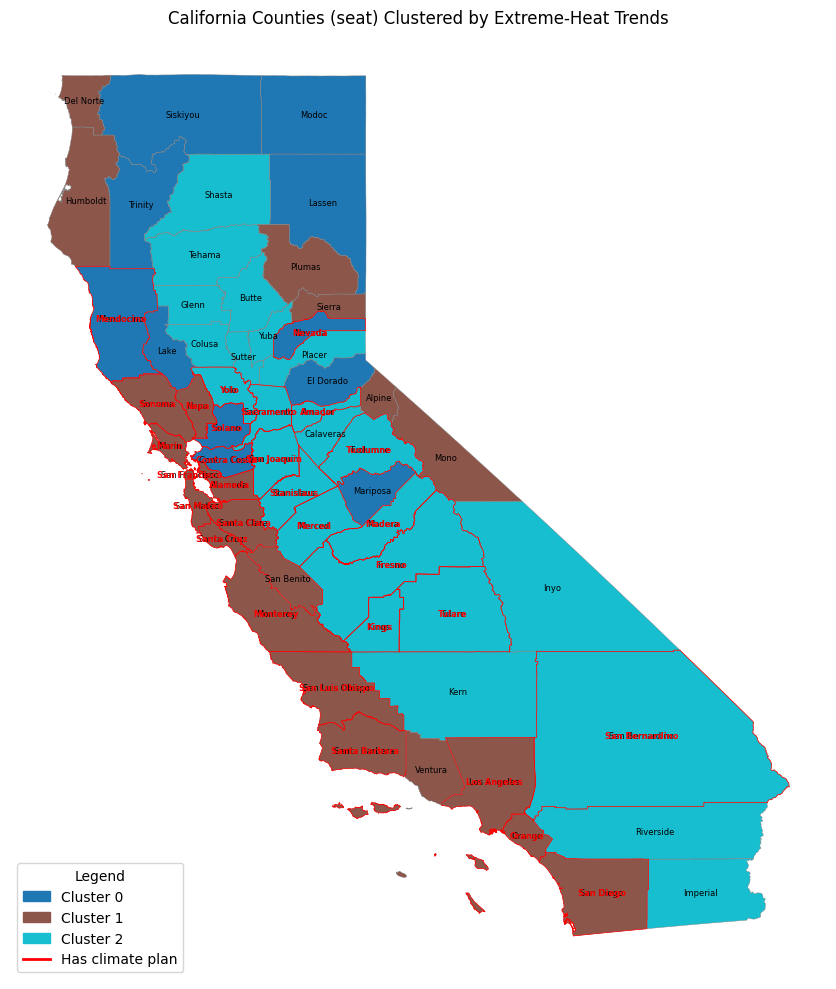

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
counties_gdf.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.3)
cmap = plt.get_cmap('tab10', int(merged['cluster'].max() + 1))
merged.plot(
    column='cluster',
    categorical=True,
    legend=False,
    cmap='tab10',
    edgecolor='none',
    ax=ax
)
if 'Plan_seat' in merged.columns:
    plan_highlight = merged[merged['Plan_seat'] == 1]
    plan_highlight.boundary.plot(ax=ax, edgecolor='red', linewidth=0.5)
for idx, row in merged.dropna(subset=['cluster']).iterrows():
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    ax.text(x, y, row['name'], fontsize=6, ha='center', va='center')
for idx, row in plan_highlight.iterrows():
    x, y = row['geometry'].centroid.x, row['geometry'].centroid.y
    ax.text(x, y, row['name'], fontsize=6, ha='center', va='center', fontweight='bold', color='red')
import matplotlib.patches as mpatches
cluster_ids = sorted(merged['cluster'].dropna().unique().astype(int))
cluster_patches = [mpatches.Patch(color=cmap(i), label=f'Cluster {i}') for i in cluster_ids]
import matplotlib.lines as mlines
plan_patch = mlines.Line2D([], [], color='red', linewidth=2, label='Has climate plan')
handles = cluster_patches + [plan_patch]
ax.legend(handles=handles, title='Legend', loc='lower left')
ax.set_title('California Counties (seat) Clustered by Extreme-Heat Trends')
ax.set_axis_off()
plt.tight_layout()
plt.show()

### Next steps:
Interactivity & improved visuals

Weighting by socioeconomic factors e.g., SVI